<a href="https://colab.research.google.com/github/GHes31415/Generative-Modeling/blob/main/NeuralODE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ref: https://www.youtube.com/watch?v=sIFnARdTVvE
import torch.nn as nn
import torch.optim as optim
import torch
import torch.functional as F

import numpy as np

from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

!pip install torchdiffeq
from torchdiffeq import odeint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def euler(func,t,dt,y):
  return dt*func(t,y)

In [ ]:
def rk4(func,t,dt,y):
  k1 = func(t,y)
  k2 = func(t+dt/2,y+dt*k1/2)
  k3 = func(t+dt/2,y+dt*k2/2)
  k4 = func(t+dt, y+dt*k3)

  return (k1+2*(k2+k3)+k4)*dt/6



# Neural ODE

In [ ]:
# Neural ODE model

class NeuralODE(nn.Module):
  def __init__(self,func):
    super().__init__()
    self.func = func

  def forward(self,y0,t,solver):
    solution = torch.empty(size =(len(t),*y0.shape),dtype = y0.dtype,device = y0.device)
    solution[0] = y0

    
    for j,t in enumerate(zip(t[:-1],t[1:])):
      dt = t[1]-t[0]
      yt = solution[j].detach()
      y = yt + solver(self.func,t[0],dt,yt)
      solution[j+1] = y
    return solution

# Check our Neural ODEs

In [ ]:
y0 = torch.Tensor([0]).cuda()
t = torch.linspace(0,6*torch.pi,1500).cuda()

class cos(nn.Module):
  def forward(self,t,y):
    return torch.cos(t)

In [ ]:
ode_test = NeuralODE(func =cos()).cuda()
test_results = ode_test(y0 = y0,t = t,solver = euler).T



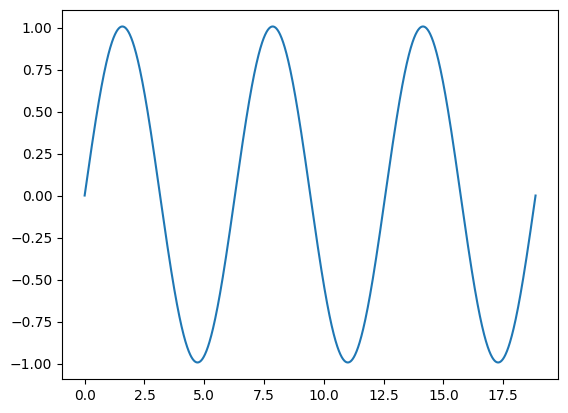

In [ ]:
plt.plot(t.cpu().numpy(),test_results[0].detach().cpu().numpy())

sprial data set

In [ ]:
data_size = 2000


In [ ]:
# generate toy dataset


true_y0 = torch.tensor([[2.0,0.]]).cuda()
t = torch.linspace(0.,25.,data_size).cuda()
true_A = torch.tensor([[-0.1,2.],[-2.,-0.1]]).cuda()

class Lambda(nn.Module):
  def forward(self,t,y):
    return torch.mm(y**3,true_A)

with torch.no_grad():
  node = NeuralODE(func = Lambda()).cuda()
  true_y = node(y0= true_y0,t = t, solver = euler)

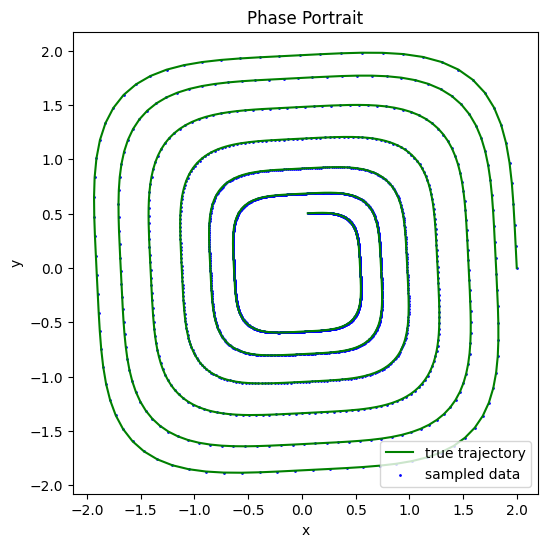

In [ ]:
def visualize(true_y,pred_y = None):
  fig = plt.figure(figsize = (6,6), facecolor = 'white')
  ax = fig.add_subplot(111)
  ax.set_title('Phase Portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(true_y.cpu().numpy()[:,0,0],true_y.cpu().numpy()[:,0,1],'green',label = 'true trajectory')
  ax.scatter(true_y.cpu().numpy()[:,0,0],true_y.cpu().numpy()[:,0,1],color ='blue',label = 'sampled data', s = 1)
  if pred_y is not None:
    ax.plot(pred_y.cpu().numpy()[:,0,0],pred_y.cpu().numpy()[:,0,1],'*r',label = 'learned trajectory')
  plt.legend()
  plt.show()

visualize(true_y)

In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time,dtype = np.int64 ), batch_size, replace = False))
  batch_y0 = true_y[s]
  batch_t = t[:batch_time]
  batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim = 0) # (time,batch_size,1,emb)
  return batch_y0.cuda(),batch_t.cuda(), batch_y.cuda()


In [ ]:
class ODEFunc(nn.Module):
  def __init__(self,num_layers,input_dim,hidden_dim,output_dim):
    super().__init__()
    layers = []
    dims = [input_dim] + [hidden_dim]*num_layers + [output_dim]
    for i in range(num_layers + 1):
      layers.append(nn.Linear(dims[i],dims[i+1]))
      if i<num_layers:
        layers.append(nn.Tanh())

    self.net = nn.Sequential(*layers)

    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight,mean = 0, std = 0.1)
        nn.init.constant_(m.bias,val= 0 )

  def forward(self,t,y):

    output = self.net(y**3)

    return output

  

  0%|          | 0/1001 [00:00<?, ?it/s]

Iter0000| Total Loss 11.137674


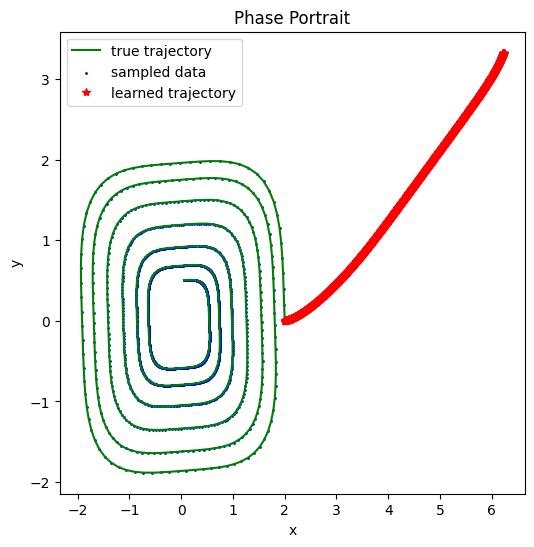

Iter0150| Total Loss 2.211184


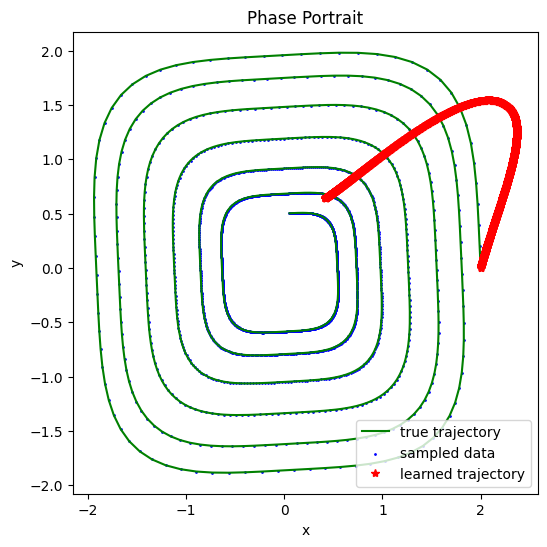

Iter0300| Total Loss 1.594746


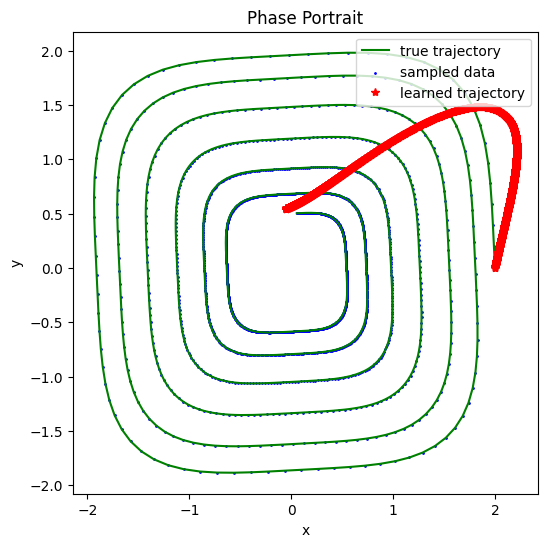

Iter0450| Total Loss 1.384195


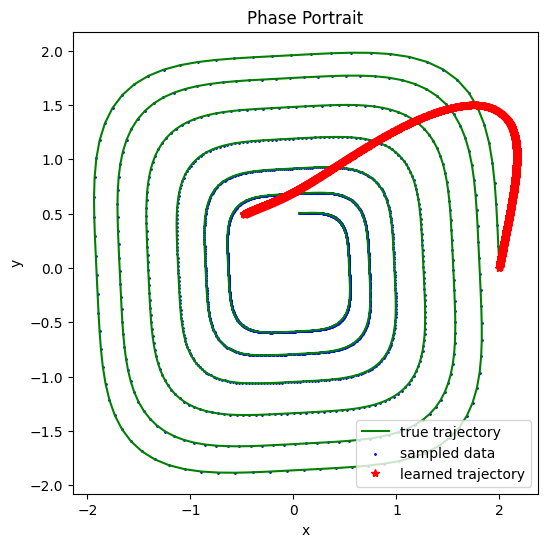

Iter0600| Total Loss 1.294790


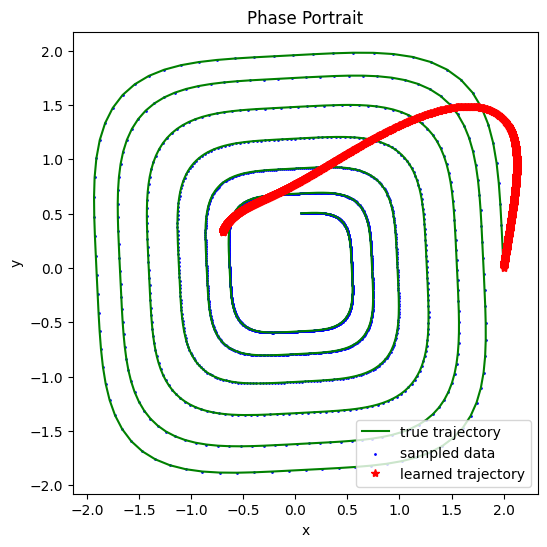

Iter0750| Total Loss 1.272575


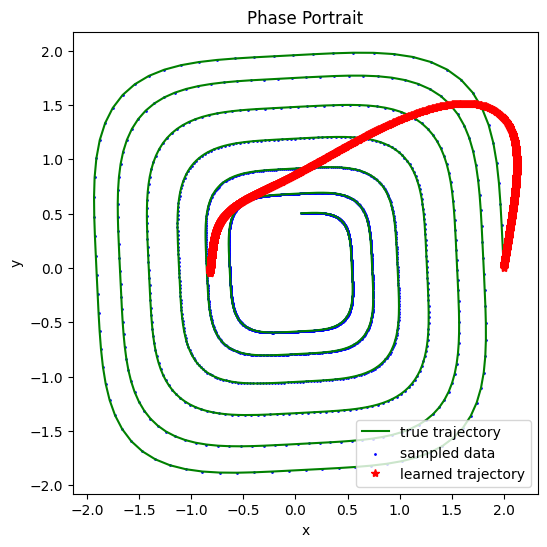

Iter0900| Total Loss 1.285242


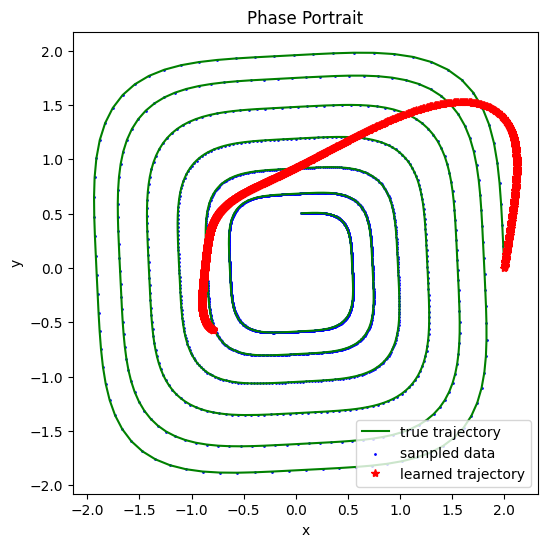

processig time: 67.68155860900879 sec


In [ ]:
# Train 

niters = 1000

# ODE architecture
num_layers = 3
input_dim = 2
hidden_dim = 50
output_dim = 2

#Assign model and define optimizer
node = NeuralODE(func = ODEFunc(num_layers= num_layers,input_dim = input_dim, hidden_dim=hidden_dim, output_dim=output_dim)).cuda()
#node = NeuralODE(func = ODEFunc()).cuda()
optimizer = optim.RMSprop(node.parameters(),lr = 1e-5)
criterion = nn.MSELoss()


start_time = time.time()


for iter in tqdm(range(niters +1)):
  # zero grad to optimizer 
  optimizer.zero_grad()
  batch_y0,batch_t,batch_y = get_batch()
  pred_y = node(y0 = batch_y0, t = batch_t, solver = rk4)
  #print(batch_y.squeeze())
  #loss = criterion(batch_y,pred_y)
  loss = torch.mean(torch.abs(pred_y-batch_y))
  # torch.autograd.set_detect_anomaly(True)
  loss.backward()
  optimizer.step()

  if iter%150 == 0 :
    pred_y = node(y0=true_y0,t=t,solver=rk4)
    loss = criterion(pred_y,true_y)
    print('Iter{:04d}| Total Loss {:.6f}'.format(iter,loss.item()))
    visualize(true_y.detach(),pred_y.detach())

end_time = time.time()-start_time

print(f'processig time: {end_time} sec')

In [ ]:
pred_y = node(y0=true_y0,t=t,solver=rk4)
loss = criterion(pred_y,true_y)
print('Iter{:04d}| Total Loss {:.6f}'.format(iter,loss.item()))


Iter1000| Total Loss 1.248694


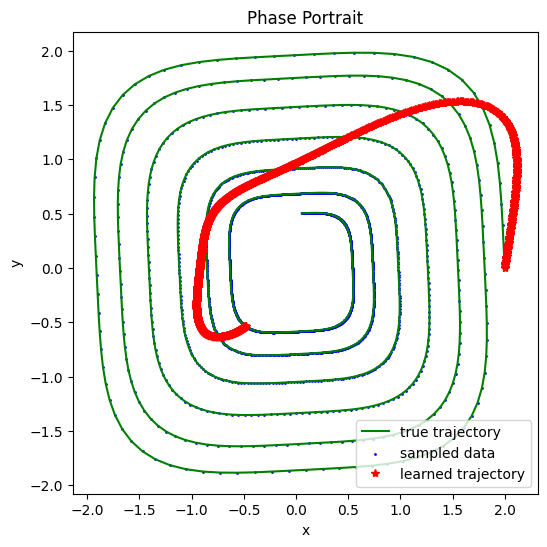

In [ ]:
visualize(true_y.detach(),pred_y.detach())

We know implement using torchdiffq

  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000 | Total Loss 60.733055


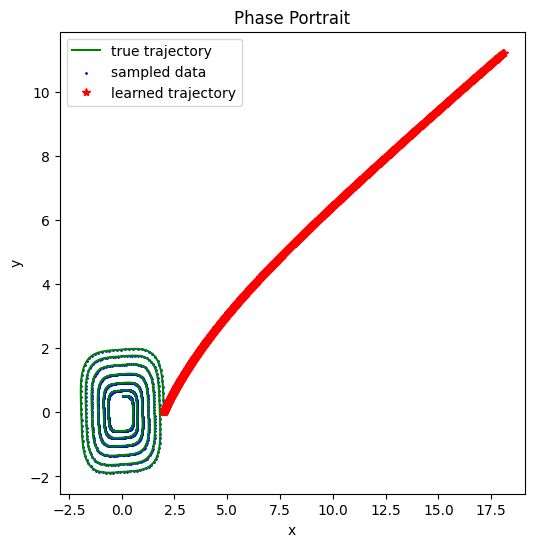

iter 0050 | Total Loss 0.817862


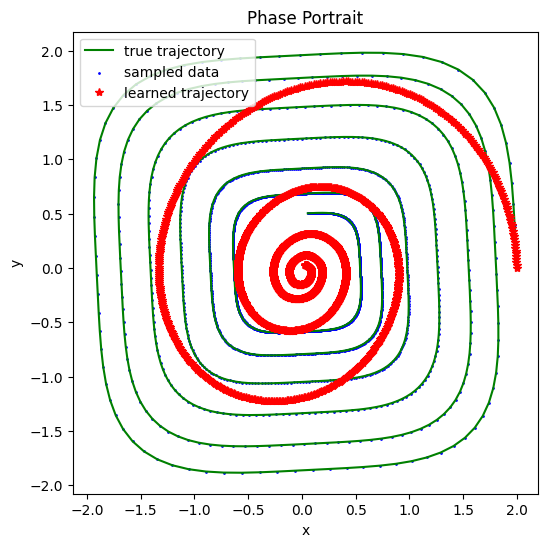

iter 0100 | Total Loss 0.646175


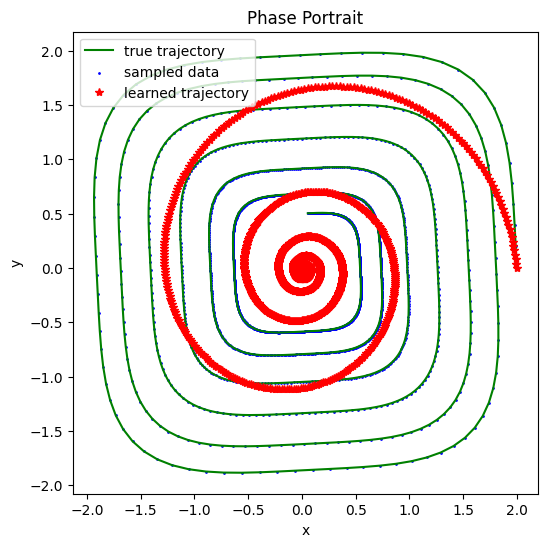

iter 0150 | Total Loss 0.873375


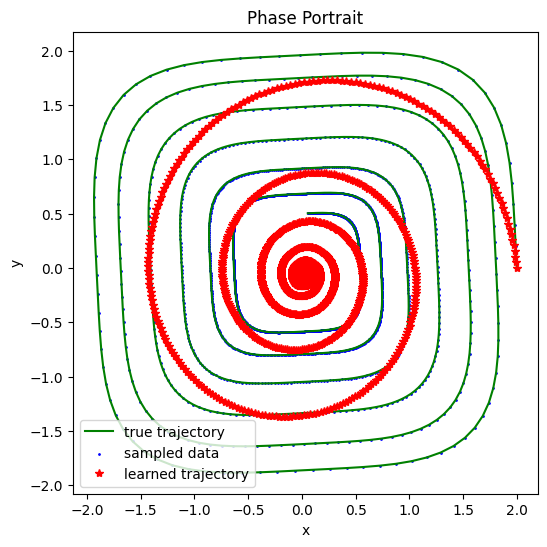

iter 0200 | Total Loss 0.657719


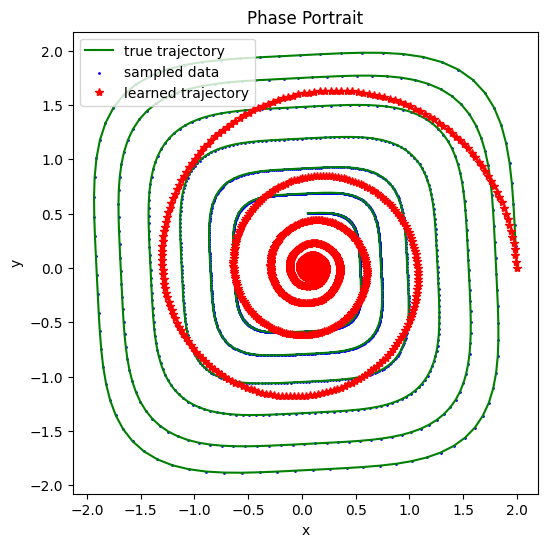

iter 0250 | Total Loss 0.620339


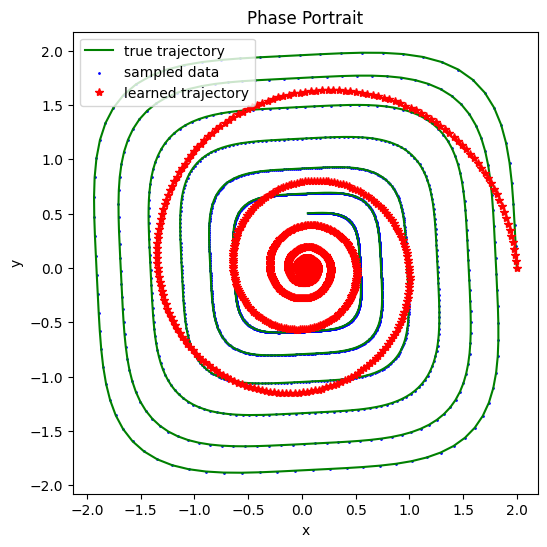

iter 0300 | Total Loss 0.575015


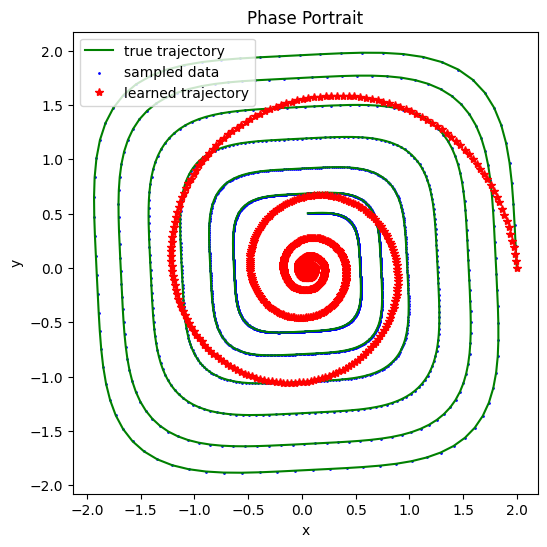

iter 0350 | Total Loss 0.574142


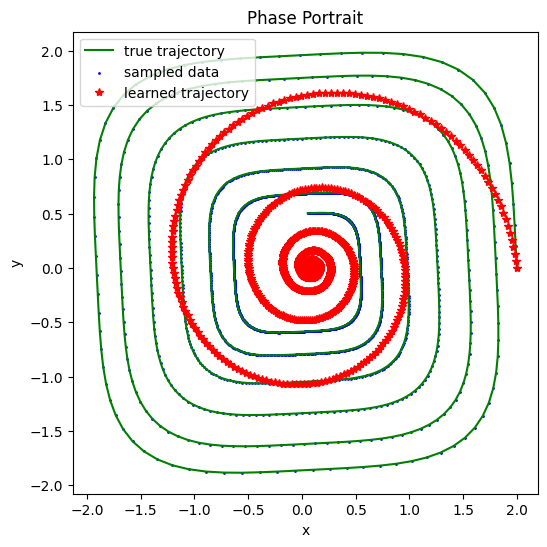

iter 0400 | Total Loss 0.573257


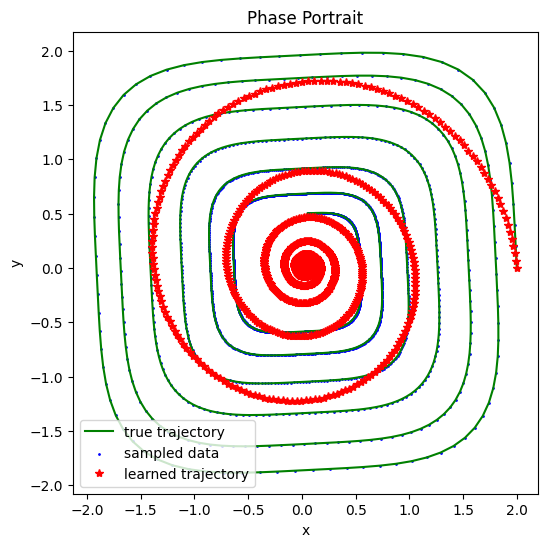

process time: 1685976027.7520738


In [ ]:
## Train

niters = 400

# ODE architecture
num_layers = 1
input_dim = 2
hidden_dim = 50
output_dim = 2

#Assign model and define optimizer
func = ODEFunc(num_layers= num_layers,input_dim = input_dim, hidden_dim=hidden_dim, output_dim=output_dim).cuda()
optimizer = optim.RMSprop(func.parameters(),lr = 1e-3)

start_time = time.time()

for iter in tqdm(range(niters+1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0 = batch_y0, t = batch_t, rtol = 1e-7, atol = 1e-9, method = 'dopri5')
  loss = criterion(pred_y,batch_y)
  loss.backward()
  optimizer.step()

  if iter % 50 == 0 :
    with torch.no_grad():
      pred_y = odeint(func, true_y0,t,rtol = 1e-7, atol= 1e-9, method = 'dopri5')
      loss = criterion(pred_y,true_y)
      print('iter {:04d} | Total Loss {:.6f}'.format(iter,loss.item()))
      visualize(true_y,pred_y)


end_time = time.time()

print(f'process time: {end_time}')

In [ ]:
from torchdiffeq import odeint_adjoint as odeint

  0%|          | 0/401 [00:00<?, ?it/s]

iter 0000 | Total Loss 151.372665


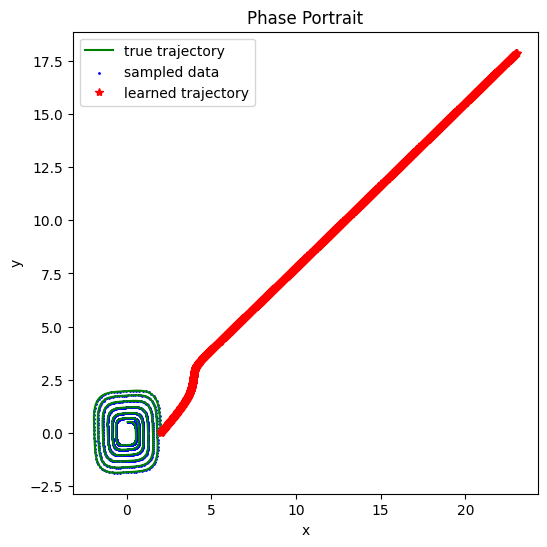

iter 0050 | Total Loss 1.406752


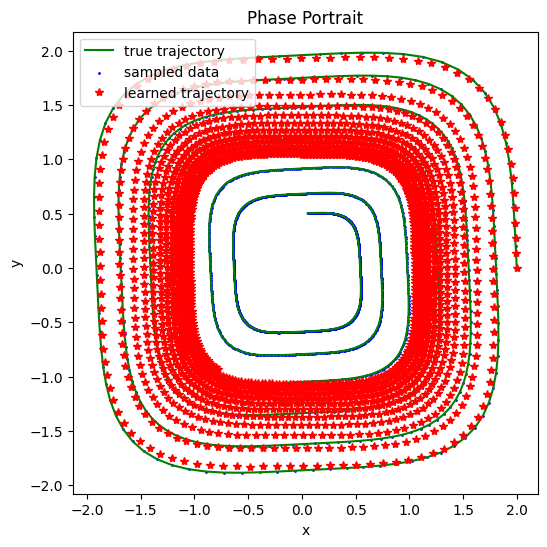

iter 0100 | Total Loss 0.828543


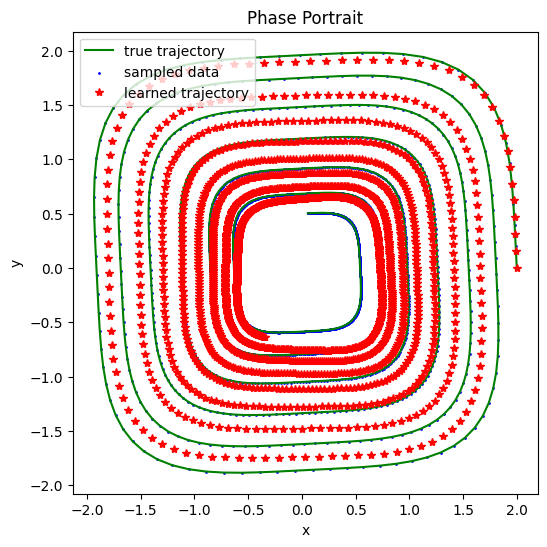

iter 0150 | Total Loss 0.703045


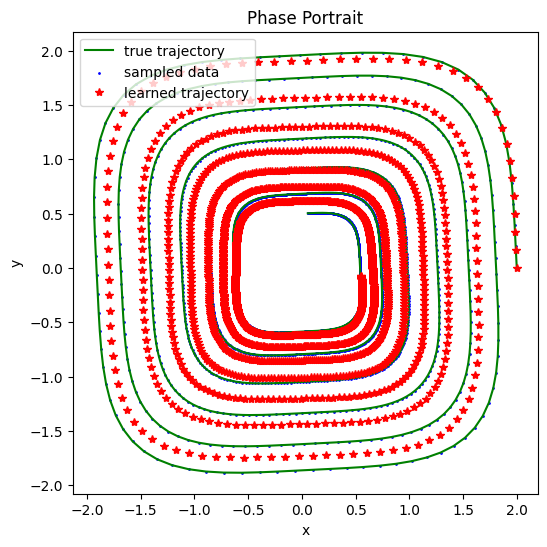

iter 0200 | Total Loss 0.601620


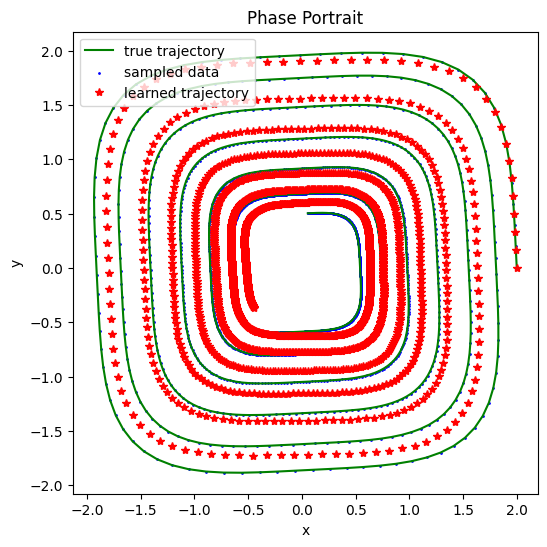

iter 0250 | Total Loss 0.721051


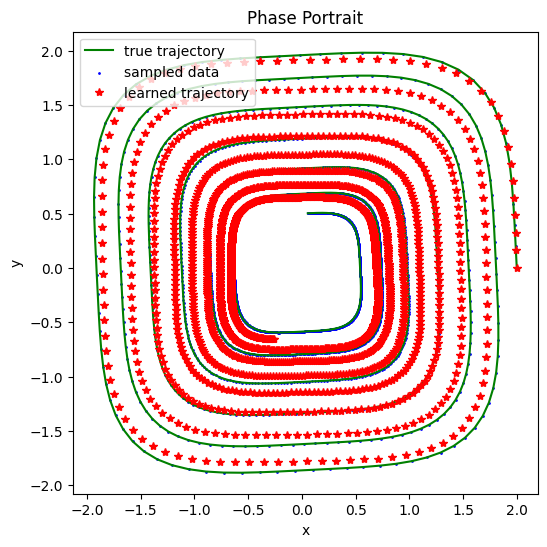

iter 0300 | Total Loss 0.788198


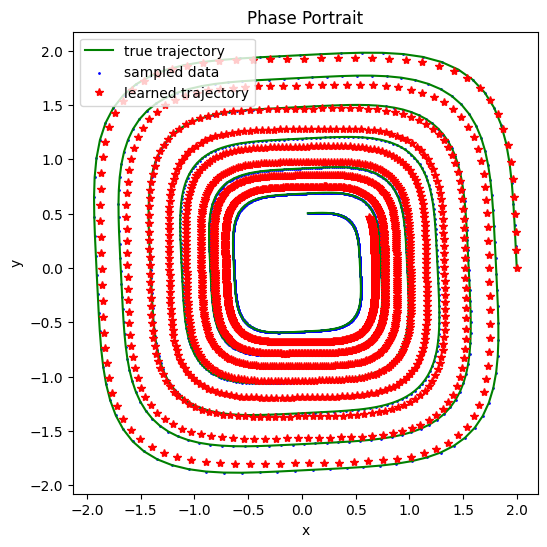

iter 0350 | Total Loss 1.259441


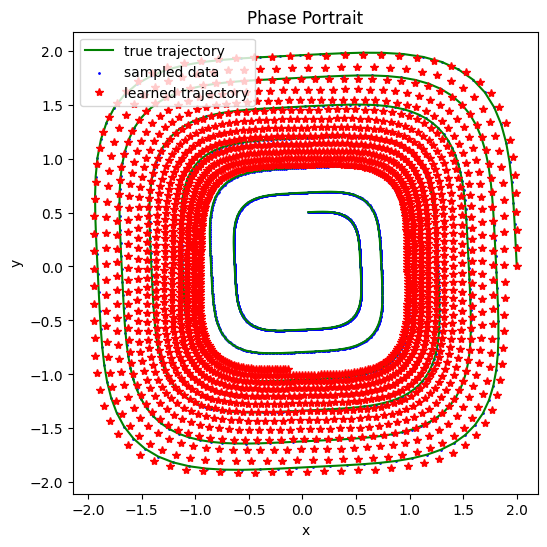

iter 0400 | Total Loss 0.881186


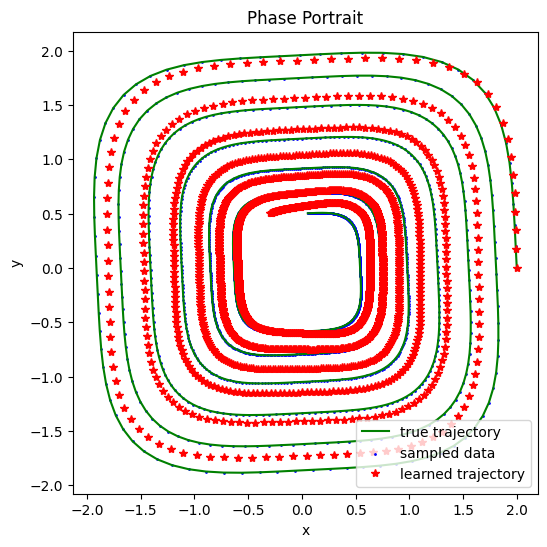

process time: 1685977457.0599396


In [ ]:
 ## Train

niters = 400

# ODE architecture
num_layers = 1
input_dim = 2
hidden_dim = 150
output_dim = 2

#Assign model and define optimizer
func = ODEFunc(num_layers= num_layers,input_dim = input_dim, hidden_dim=hidden_dim, output_dim=output_dim).cuda()
optimizer = optim.RMSprop(func.parameters(),lr = 1e-3)

start_time = time.time()

for iter in tqdm(range(niters+1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0 = batch_y0, t = batch_t, rtol = 1e-7, atol = 1e-9, method = 'dopri5')
  loss = criterion(pred_y,batch_y)
  loss.backward()
  optimizer.step()

  if iter % 50 == 0 :
    with torch.no_grad():
      pred_y = odeint(func, true_y0,t,rtol = 1e-7, atol= 1e-9, method = 'dopri5')
      loss = criterion(pred_y,true_y)
      print('iter {:04d} | Total Loss {:.6f}'.format(iter,loss.item()))
      visualize(true_y,pred_y)


end_time = time.time()

print(f'process time: {end_time}')